# Simulation of a positron-induced Muon Source (part 1)


### Authors:
* Saverio Monaco
* Marianna Zeragic De Giorgio
* Gerardo Javier Carmona
* Hilario Capettini 

### Description

The production of a high brillance muon beam is one of the most important challenge for the future of Particle Physics. A particularly interesting idea consists of shooting high energy positrons on a target, aiming at the production of muons by means of the process $e^+ + e^- \rightarrow \mu^+ + \mu^-$. To mimize the divergence of the resulting "muon beam", the positrons energy is chosen so that the reaction occurs close to threshold (assuming the electrons in the target to be at rest). The main goal of this project is to produce a Monte Carlo simulation of such a process. 


### References

* [LEMMA](https://arxiv.org/pdf/1509.04454.pdf) paper. The original paper describing the positron-induced low emittance muon source, ehere all the relevant kinematic features of the process have been studied
* [Babayaga](https://www2.pv.infn.it/~hepcomplex/babayaga.html) event generator. You may want to install and run it as a comparison for your results.
* [2018 Experiment](https://arxiv.org/pdf/1909.13716.pdf): the paper describing the (very poor..) results of the experiment carried out in summer 2018
* [2021 proposal](https://cds.cern.ch/record/2712394?ln=en): the proposal for the experiment in 2021


### Contact

* Marco Zanetti <marco.zanetti@unipd.it>
* Camilla Curatolo <camilla.curatolo@pd.infn.it>
* Jacopo Pazzini <jacopo.pazzini@unipd.it>
* Alberto Zucchetta <alberto.zucchetta@pd.infn.it>

## Analytical part

1. Compute the process leading-order cross section, $\sigma(\theta; \sqrt{s})$, as a function of the scattering angle $\theta$ and with the  center of mass energy $\sqrt{s}$ as a parameter. Start by computing it in the center of mass system. N.B.: textbooks reports such cross section in the relativistic limit, i.e. for $\sqrt{s}\gg m_\mu$, which is clearly not the case here ($\sqrt{s}\sim 2m_\mu$);

2. compute and display the angle and momentum components distributions of the emerging muon pairs;

3. boost muons four-momenta in the laboratory frame, i.e. in the frame where the electron is at rest and the positron has enough energy to give rise to the process;

In [1]:
#ADD THEORETICAL RESULTS

In [102]:
#Import the required packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.integrate as integrate
import csv
import pandas as pd
from matplotlib.ticker import FormatStrFormatter

In [3]:
#Define the universal constants
muon_mass       = 0.1056583745       #[GeV]
electrom_mass   = 0.00051099894      #[GeV]
electron_charge = 1.602176634e-19    #[C]
c = 299792458                        #[m/s]
alpha = 0.007297                     #[]    #CHECK



The differential cross section we choosed is then $$\left(\frac{d\sigma}{d\Omega}\right)_{CM}=\frac{\alpha^2}{16\, s^2}\frac{|p'|}{\sqrt{s}}\left(s+p'^2\cos^2\vartheta+m_\mu^2\right)$$

The relativistic total energy is $$E_{CM}^2=4p'^2+4m_\mu^2\rightarrow p'^2=\frac{E_{CM}^2}{4}-m_\mu^2\rightarrow p'^2=\frac{s}{4}-m_\mu^2$$

Then our differential cross section becomes:
$$\left(\frac{d\sigma}{d\Omega}\right)_{CM}=\frac{\alpha^2}{16\, s}\sqrt{\frac{1}{4}-\frac{m_\mu^2}{s}}\left[\left(1+\frac{m_\mu^2}{s}\right)+\left(\frac{1}{4}- \frac{m_\mu^2}{s}\right)\cos^2{\theta}\right]$$

Integrating over the solid angle we obtain the total cross section:
$$\sigma(s)=\frac{\pi \alpha^2}{4\, s}\sqrt{\frac{1}{4}-\frac{m_\mu^2}{s}}\left[\frac{13}{12}+\frac{2}{3}\frac{m_\mu^2}{s}\right]$$

The PDF for a given energy s is given by:
$$PDF(\theta)=  \int_{0}^{2 \pi} \sin(\theta)\frac{d\sigma}{d\Omega} d\phi $$

In [4]:
#rs is the sqrt(s)
#The unis are Barn so 1ub = 2.56819e-3  GeV^-2  #CHECK!!!
gev_to_ub = 389.379

def cros_section(rs):
    y = np.pi * alpha**2 / (4*rs**2) * np.sqrt(1/4 - muon_mass**2 / rs**2) * (13/12 + 2/3 * muon_mass**2 / rs**2)
    #y = 1 * np.pi * alpha**2 / (3*rs**2) * np.sqrt(1 - 4*muon_mass**2 / rs**2) * (1 + 2 * muon_mass**2 / rs**2)
    return y * gev_to_ub
    
def dif_cross_section(rs,theta):
    y = alpha**2/(16 * rs**2)* np.sqrt(1/4 - muon_mass**2/rs**2) * (1 + muon_mass**2 / rs**2 + (1/4 -muon_mass**2/rs**2)*np.cos(theta)**2)
    #y = alpha**2/(16 * rs**2)* np.sqrt(1 - 4*muon_mass**2/rs**2) * (1 + 4*muon_mass**2 / rs**2 + (1 -4*muon_mass**2/rs**2)*np.cos(theta)**2)
    return y * gev_to_ub

def pdf_theta(rs,theta):
    y = 2*np.pi *np.sin(theta)*dif_cross_section(rs,theta)
    return y
    
def pdf_theta_normalized(rs,theta):
    y =pdf_theta(rs,theta)/cros_section(rs)
    return y




def pdf_p(rs,theta):
    y = 0
    return y
    
def pdf_p_normalized(rs,theta):
    y =pdf_p(rs,theta)/cros_section(rs)
    return y

In [34]:
#Simulation constants
E = 2 * muon_mass + 0.001  #This is the proposed energy just above the threshold
N = 10**7

In [35]:
print(np.sqrt(E**2/4-muon_mass**2))
print(E)
print(cros_section(E))

0.010291179451355442
0.212316749
0.021858933687186603


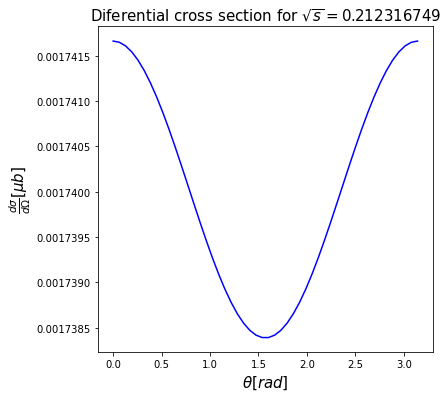

In [36]:
fig, ax = plt.subplots(figsize=(6,6))
theta = np.linspace(0,np.pi)
ax.plot(theta, dif_cross_section(E,theta),color='blue', label='PDF')

plt.title(r'Diferential cross section for $\sqrt{s}=$'+str(E), fontsize=15)
plt.xlabel(r'$ \theta [rad] $', fontsize=15)
plt.ylabel(r'$ \frac{d\sigma}{d\Omega} [\mu b]$', fontsize=15)
#plt.legend()
plt.show()

<ipython-input-4-5edc05401cfb>:6: RuntimeWarning: invalid value encountered in sqrt
  y = np.pi * alpha**2 / (4*rs**2) * np.sqrt(1/4 - muon_mass**2 / rs**2) * (13/12 + 2/3 * muon_mass**2 / rs**2)
<ipython-input-4-5edc05401cfb>:6: RuntimeWarning: invalid value encountered in sqrt
  y = np.pi * alpha**2 / (4*rs**2) * np.sqrt(1/4 - muon_mass**2 / rs**2) * (13/12 + 2/3 * muon_mass**2 / rs**2)


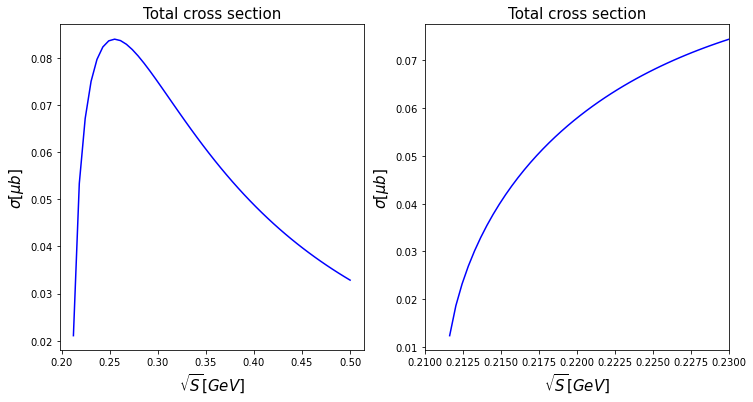

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
rs = np.linspace(0.2, 0.5)
ax1.plot(rs, cros_section(rs),color='blue', label='PDF')

ax1.set_title('Total cross section', fontsize=15)
ax1.set_xlabel(r'$ \sqrt{S} [GeV]$', fontsize=15)
ax1.set_ylabel(r'$ \sigma [\mu b]$', fontsize=15)
#plt.legend()

rs = np.linspace(0.21, 0.23)
ax2.plot(rs, cros_section(rs),color='blue', label='PDF')

ax2.set_title('Total cross section', fontsize=15)
ax2.set_xlabel(r'$ \sqrt{S} [GeV]$', fontsize=15)
ax2.set_ylabel(r'$ \sigma [\mu b]$', fontsize=15)
ax2.set_xlim(0.21,0.23)
plt.show()

Angle distribution


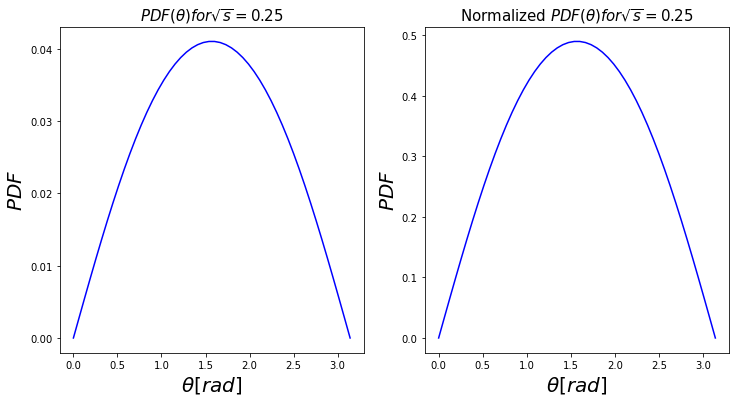

Check the normalization
Integral of the PDF in [0,pi] 0.08369812561149251

Integral of the normalized PDF in [0,pi] 0.9999999999999999


In [38]:
print('Angle distribution')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

E = 0.25
theta = np.linspace(0, np.pi)


ax1.plot(theta, pdf_theta(E,theta),color='blue', label='PDF')
ax1.set_title(r'$ PDF(\theta) for \sqrt{s}=$'+str(E), fontsize=15)
ax1.set_xlabel(r'$ \theta [rad] $', fontsize=20)
ax1.set_ylabel(r'$ PDF$', fontsize=20)
#plt.legend()



ax2.plot(theta, pdf_theta_normalized(E,theta),color='blue', label='PDF')
ax2.set_title(r'Normalized $ PDF(\theta) for \sqrt{s}=$'+str(E), fontsize=15)
ax2.set_xlabel(r'$ \theta [rad] $', fontsize=20)
ax2.set_ylabel(r'$ PDF$', fontsize=20)
plt.show()

print('Check the normalization')
x2 = lambda x: pdf_theta(E,x)
print('Integral of the PDF in [0,pi]',integrate.quad(x2, 0., np.pi)[0])
print('')
x2 = lambda x: pdf_theta_normalized(E,x)
print('Integral of the normalized PDF in [0,pi]',integrate.quad(x2, 0., np.pi)[0])

In [39]:
print('Momentum distribution')

Momentum distribution


## Monte Carlo Simulation

4. write a Monte Carlo simulation that generates scattering events following the distrubtions that you found analytically; 
5. produce a synthetic dataset of about $N=10^5$ (or more) events. Events should be listed as rows in a file with columns representing the muons coordinates (keep in mind that in the lab frame muons are relativistic and thus the number of coordinates can be only 3 per muon);
6. assume a $3$ cm thick Beryllium block is used as target and a rate of positron on target of $10^6$ Hz. Compute the rescaling factor (weight) you need to apply to the $N$ simulated events such that they represent the statistics that would be gathered in a week of countinuous operations;
7. repeat what done so far simulating now the actual transverse shape and energy spread of the beam: for the former assume a flat distribution in a circle of radius $r=1$ cm and for the latter a gaussian distribution centered at the nominal beam energy and a width of $0.5$ GeV;


In [40]:
#Inputs

box = [0,np.pi,0.0,0.5] #Box coordinates [x0,x1,y0,y1] for analysis
                        #We choose the size to optimize the ammount of useful particles

In [41]:
def distribution(theta):
    rs = E  
    y = pdf_theta_normalized(rs,theta) 
    return y

In [42]:
def accept_reject(N,distribution,box):
    x = np.random.uniform(box[0], box[1], N)
    y = np.random.uniform(box[2], box[3], N)
    
    accepted = x[y<=distribution(x)]
    return accepted
   

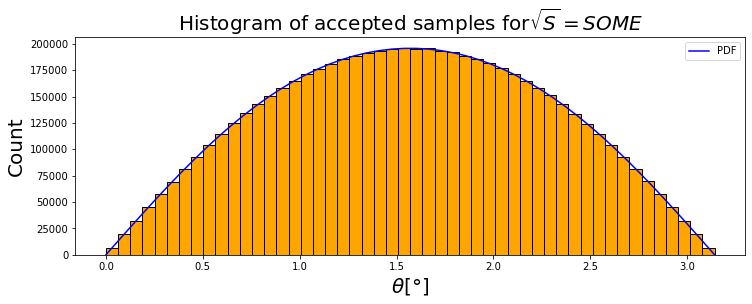

In [43]:
# Plot scaled histogram
fig, ax = plt.subplots(figsize=(12,4))

n, bins, _ = ax.hist(accept_reject(N,distribution,box), bins=50,color='orange', ec='black')

d = (bins[1]-bins[0])
scaling = d * n.sum()

theta = np.linspace(box[0], box[1])
ax.plot(theta, distribution(theta)*scaling,color='blue', label='PDF')


plt.title('Histogram of accepted samples for'r'$ \sqrt{S}=SOME$', fontsize=20)
plt.xlabel(r'$ \theta [°]$', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.legend()
plt.show()

In [24]:
#Comparison with BabaYaga algorithm



In [ ]:
#File management
#csvfile=open('persons.csv','w', newline='')

In [47]:
#Obtain the parameters distribution
theta_instances = accept_reject(N,distribution,box)
N_instances = len(theta_instances)
phi_instances = np.random.uniform(0., 2*np.pi, N_instances)

p = np.sqrt(E**2/4-muon_mass**2)

In [62]:
#Obtain the muons momenta and build the file  (Is it in the CoM frame?)

pxm = p * np.sin(theta_instances)*np.cos(phi_instances)
pym = p * np.sin(theta_instances)*np.sin(phi_instances)
pzm = p * np.cos(theta_instances)

pxam = -pxm
pyam = -pym
pzam = -pzm

df = pd.DataFrame({'Theta' : theta_instances,'Phi' : phi_instances,'Muon px' : pxm, 'Muon py' : pym, 'Muon pz' : pzm})
df.to_csv('/home/usuario/PoD/submission2.csv', index=False)

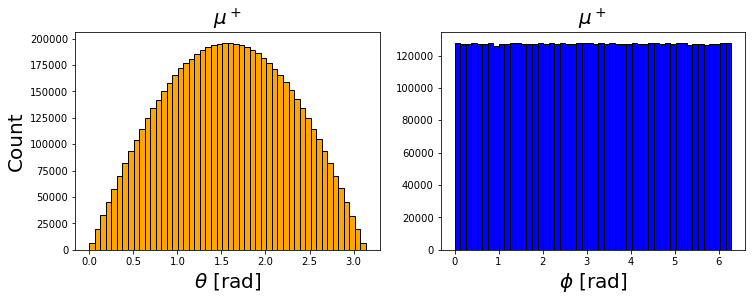

In [110]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

n, bins, _ = ax1.hist(theta_instances, bins=50,color='orange', ec='black')
ax1.set_title(r'$\mu^+$', fontsize=20)
ax1.set_xlabel(r'$\theta$ [rad]', fontsize=20)
ax1.set_ylabel('Count', fontsize=20)

n, bins, _ = ax2.hist(phi_instances, bins=50,color='blue', ec='black')
ax2.set_title(r'$\mu^+$', fontsize=20)
ax2.set_xlabel(r'$\phi$ [rad]', fontsize=20)




plt.show()

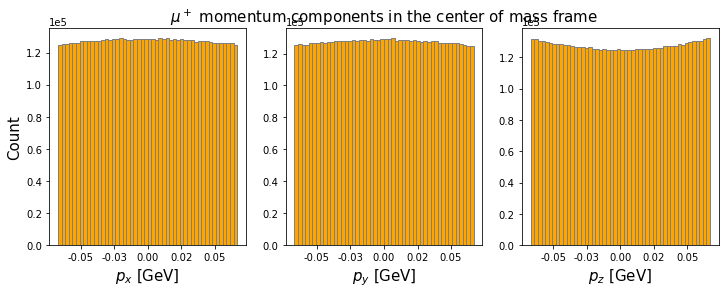

In [105]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

n, bins, _ = ax1.hist(pxm, bins=50,color='orange', ec='grey')
ax1.set_xlabel(r'$p_x$ [GeV]', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


n, bins, _ = ax2.hist(pym, bins=50,color='orange', ec='grey')
ax2.set_title(r'$\mu^+$ momentum components in the center of mass frame', fontsize=15)
ax2.set_xlabel(r'$p_y$ [GeV]', fontsize=15)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))



n, bins, _ = ax3.hist(pzm, bins=50,color='orange', ec='grey')
ax3.set_xlabel(r'$p_z$ [GeV]', fontsize=15)
ax3.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))



plt.show()

In [ ]:
#Inser Pandas table with some statistics



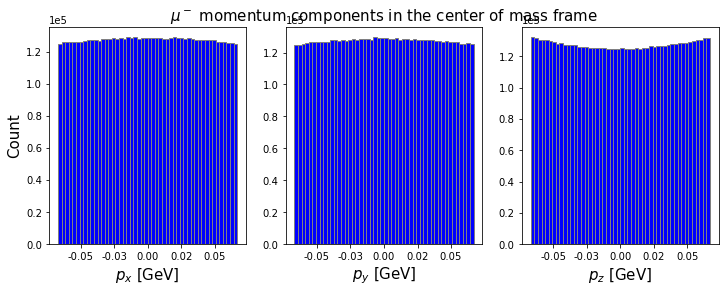

In [106]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

n, bins, _ = ax1.hist(pxam, bins=50,color='b', ec='grey')
ax1.set_xlabel(r'$p_x$ [GeV]', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

n, bins, _ = ax2.hist(pyam, bins=50,color='blue', ec='grey')
ax2.set_title(r'$\mu^-$ momentum components in the center of mass frame', fontsize=15)
ax2.set_xlabel(r'$p_y$ [GeV]', fontsize=15)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


n, bins, _ = ax3.hist(pzam, bins=50,color='blue', ec='grey')
ax3.set_xlabel(r'$p_z$ [GeV]', fontsize=15)
ax3.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


plt.show()

In [ ]:
#Inser Pandas table with some statistics




In [ ]:
#Boost the results to the laboratory frame


In [ ]:
#Realistic target

In [ ]:
#Realistic beam

## Aditional considerations

8. given that the electrons traversing the target lose energy as $E(z)=E_0 \exp{-z/X_0}$ (with z the longitudinal coordinate of the target, the one parallel to the beam direction and $X_0$ is the Beryllium radiation length), compute the nominal beam energy $E_0$ such that muon pairs can be generated along the whole length of the target;
9. (optional) take the former point into account when generating the events (i.e. the proccess $\sqrt{s}$ depend on the position along the target where the $e^+ - e^-$ scattering occurrs.

